In [1]:
import prior

dataset = prior.load_dataset("procthor-10k")
dataset

[AI2-THOR WARNING] There has been an update to ProcTHOR-10K that must be used with AI2-THOR version 5.0+. To use the new version of ProcTHOR-10K, please update AI2-THOR to version 5.0+ by running:
    pip install --upgrade ai2thor
Alternatively, to downgrade to the old version of ProcTHOR-10K, run:
   prior.load_dataset("procthor-10k", revision="ab3cacd0fc17754d4c080a3fd50b18395fae8647")


Loading test: 100%|██████████| 1000/1000 [00:00<00:00, 11887.98it/s]


DatasetDict(
    train=Dataset(
    dataset=procthor-dataset,
    size=10000,
    split=train
),
    val=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=val
),
    test=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=test
)
)

In [2]:
from ai2thor.controller import Controller


house = dataset["train"][3]
controller = Controller(scene=house, snapToGrid=False, rotateStepDegrees=30)
event = controller.step("Pass")
spawn = event.metadata["agent"]["position"]

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


In [3]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from rl import RNDIntrinsicReward
import numpy as np

# RND Trial (Can be skipped)

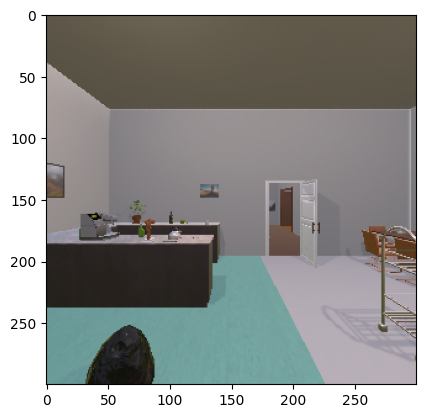

In [4]:
rnd_try = RNDIntrinsicReward()
event = controller.step(
    action="TeleportFull",
    x=spawn["x"],
    y=spawn["y"],
    z=spawn["z"],
    rotation={"x": 0, "y": 90, "z": 0},
    horizon=0,
    standing=True
)
plt.imshow(event.frame)

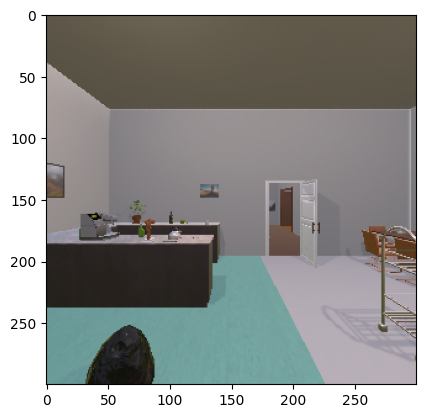

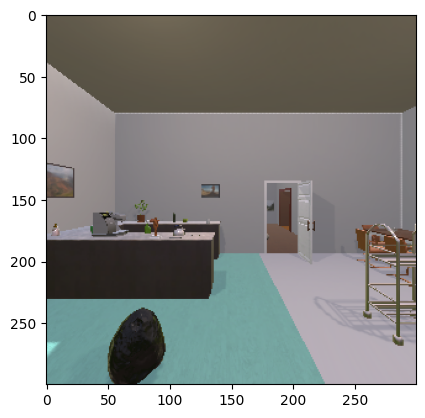

[0.7344093971689443, 0.7131367356217102, 0.6932406440966584, 0.6749024045377497, 0.6575366650646932] 0.6564563298337028


In [5]:
event = controller.step("Pass")

rws = []
for i in range(5):
    rw1 = rnd_try.compute_reward(rnd_try.pre_process_rnd(event))
    rws.append(rw1)
plt.imshow(event.frame)
plt.show()
event = controller.step("MoveBack")
plt.imshow(event.frame)
plt.show()
rw3 = rnd_try.compute_reward(rnd_try.pre_process_rnd(event))
print(rws, rw3)
# plt.imshow(event.frame.copy())

# Start Training

In [8]:
def teleport(controller, target=None):
    event = controller.step("GetReachablePositions")
    reachable_positions = event.metadata["actionReturn"]
    # Pick a random target
    if target is None:
        target = np.random.choice(reachable_positions)

    event = controller.step(
        action="TeleportFull",
        x=target["x"],
        y=target["y"],
        z=target["z"],
        rotation={"x": 0, "y": 0, "z": 0},
        horizon=0,
        standing=True
    )

    return event


In [4]:
from rl import PPO, ActorCritic, Env, RolloutBuffer, RNDIntrinsicEnv, ClipEnv, CLIPNovelty
from models import Actor, Critic, FrozenResNetEncoder
from cons import MINIBATCHES, EPISODE_STEPS, FEAT_DIM, NUM_ACTIONS, DEVICE

In [5]:
def train(controller, ppo: PPO, env: Env, actor_critic: ActorCritic, total_updates=10):
    event = controller.step("Pass")  # prime
    rewards = []
    episode_rewards = []
    for upd in range(total_updates):
        buf = RolloutBuffer()
        for mb in range(MINIBATCHES):
            # collect episodes
            episode_seq = []
            episode_reward = 0
            for t in range(1, EPISODE_STEPS + 1):
                obs_t = ppo.obs_from_event(event)  # (C,H,W)
                obs_seq = torch.stack(episode_seq + [obs_t], dim=0).unsqueeze(0).to(device=DEVICE)
                logits, value = ppo.act_and_value(obs_seq, actor_critic)
                dist = torch.distributions.Categorical(logits=logits)
                action_idx = dist.sample()
                logp = dist.log_prob(action_idx)
                
                action_idx, logp = action_idx.item(), logp.item()
                event, reward = env.step_env(controller, action_idx)
                done = t == EPISODE_STEPS

                # store one step
                buf.add(obs_t, action_idx, logp, reward, value, done)
                episode_seq.append(obs_t)
                rewards.append(reward)
                episode_reward += reward / EPISODE_STEPS

                # 50% chance of teleport
                if done and np.random.rand() > 0.5:
                    event = teleport(controller)
                    env.reset()
            episode_rewards.append(episode_reward)
                
        ppo.ppo_update(buf, actor_critic)
        print(f"Update {upd+1}/{total_updates} — steps: {len(buf)}")
        plt.plot(rewards)
        plt.show()
        plt.plot(episode_rewards)
        plt.show()
    return buf, rewards

In [8]:
rnd_reward = RNDIntrinsicReward()
rnd_intrinsic_env = RNDIntrinsicEnv(rnd_reward)
rnd_actor_critic = ActorCritic()
buf, rewards = train(ppo, controller, rnd_intrinsic_env, rnd_actor_critic, 1)

TypeError: ActorCritic.__init__() missing 3 required positional arguments: 'encoder', 'actor', and 'critic'

# Final Inference

In [78]:
import matplotlib.pyplot as plt
import numpy as np

n = 120
n_row = 8
positions = []

plt.figure(figsize=(n // n_row, n_row))
event = teleport(controller)

episode_seq = []
for t in range(1, n + 1):
    obs_t = obs_from_event(event)  # (C,H,W)
    obs_seq = torch.stack(episode_seq + [obs_t], dim=0).unsqueeze(0)
    logits, value = act_and_value(obs_seq)
    dist = torch.distributions.Categorical(logits=logits)
    print(logits.shape)
    print(torch.softmax(logits, dim=0))
    action_idx = dist.sample()
    # action_idx = np.random.randint(0, 4)

    event, reward = rnd_intrinsic_env.step_env(controller, action_idx)
    done = t == EPISODE_STEPS

    # Extract agent position from metadata
    pos = event.metadata["agent"]["position"]
    positions.append((pos["x"], pos["z"]))  # store x,z

    # Plot frame and action
    plt.subplot(n_row, n // n_row, t)
    plt.title("action: " + ACTIONS[action_idx] + ", r: " + f"{reward:.2f}", fontsize=5)
    plt.axis(False)
    plt.imshow(event.frame)

plt.tight_layout()
plt.show()

# ---- Plot 2D trajectory of the agent ----
positions = np.array(positions)
plt.figure(figsize=(4, 4))
plt.plot(positions[:, 0], positions[:, 1], "-o", markersize=3)
plt.xlabel("x")
plt.ylabel("z")
plt.title("Agent trajectory over n steps")
plt.grid(True)
plt.show()


TypeError: act_and_value() missing 1 required positional argument: 'actor_critic'

<Figure size 1500x800 with 0 Axes>

In [18]:
controller.stop()

# CLIP Novelty - Transformer

[PPO] Epoch 0: Loss=6.6011, Policy=0.0040, Value=13.3441
[PPO] Epoch 10: Loss=0.7249, Policy=-0.0103, Value=1.6142
[PPO] Epoch 20: Loss=0.6410, Policy=-0.0280, Value=1.4873
[PPO] Epoch 30: Loss=0.5528, Policy=-0.0327, Value=1.3157
[PPO] Epoch 40: Loss=0.3995, Policy=-0.0502, Value=1.0427
[PPO] Epoch 50: Loss=0.2643, Policy=-0.0166, Value=0.7037
[PPO] Epoch 60: Loss=0.0843, Policy=-0.0658, Value=0.4469
[PPO] Epoch 70: Loss=0.0063, Policy=-0.0737, Value=0.3104
[PPO] Epoch 80: Loss=-0.0286, Policy=-0.0834, Value=0.2509
[PPO] Epoch 90: Loss=-0.0862, Policy=-0.0911, Value=0.1563
Approx KL Learned: 0.04343586415052414
Update 1/1 — steps: 1024


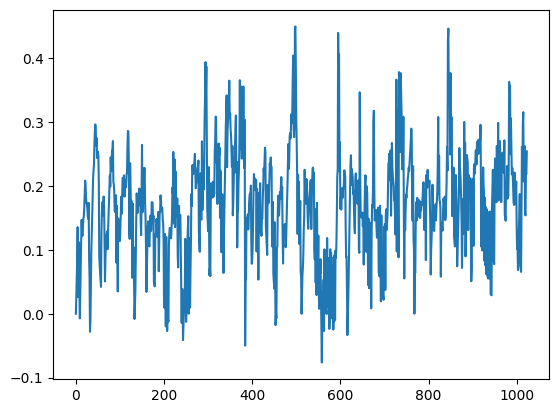

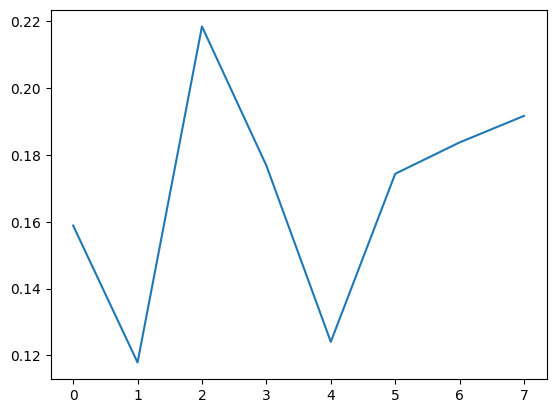

In [ ]:
ENTROPY_COEF = 0.08

ppo = PPO(ENTROPY_COEF)
encoder = FrozenResNetEncoder()
actor = Actor(FEAT_DIM, NUM_ACTIONS)
critic = Critic(FEAT_DIM)
clip_novelty = CLIPNovelty()
clip_env = ClipEnv(clip_novelty)
clip_actor_critic = ActorCritic(encoder, actor, critic)
buf, rewards = train(controller, ppo, clip_env, clip_actor_critic, 20)

# CLIP Novelty - LSTM

In [6]:
class LSTMActor(nn.Module):
    def __init__(self, feat_dim: int, num_actions: int):
        super().__init__()
        self.num_layers = 8
        self.hidden_size = feat_dim
        self.lstm = nn.LSTM(
            input_size=feat_dim,
            hidden_size=feat_dim,
            num_layers=self.num_layers,
            batch_first=True
        )
        self.head = nn.Linear(feat_dim, num_actions)

    def forward(self, X, mask=None):
        B, S, D = X.shape

        # initialize hidden states PER BATCH
        h0 = torch.zeros(self.num_layers, B, D, device=X.device)
        c0 = torch.zeros(self.num_layers, B, D, device=X.device)

        out, _ = self.lstm(X, (h0, c0))   # out: (B, S, D)
        out = out.reshape(B * S, D)
        return self.head(out)


class LSTMCritic(nn.Module):
    def __init__(self, feat_dim: int):
        super().__init__()
        self.num_layers = 8
        self.hidden_size = feat_dim
        self.lstm = nn.LSTM(
            input_size=feat_dim,
            hidden_size=feat_dim,
            num_layers=self.num_layers,
            batch_first=True
        )
        self.head = nn.Linear(feat_dim, 1)

    def forward(self, X, mask=None):
        B, S, D = X.shape

        # initialize hidden states PER BATCH
        h0 = torch.zeros(self.num_layers, B, D, device=X.device)
        c0 = torch.zeros(self.num_layers, B, D, device=X.device)

        out, _ = self.lstm(X, (h0, c0))   # out: (B, S, D)
        out = out.reshape(B * S, D)
        return self.head(out)



[PPO] Epoch 0: Loss=5.5908, Policy=0.0000, Value=11.3572
[PPO] Epoch 10: Loss=5.2924, Policy=-0.0056, Value=10.7709
[PPO] Epoch 20: Loss=4.6700, Policy=-0.0142, Value=9.5413
[PPO] Epoch 30: Loss=1.2319, Policy=-0.0142, Value=2.6654
[PPO] Epoch 40: Loss=1.1308, Policy=-0.0145, Value=2.4636
[PPO] Epoch 50: Loss=1.0830, Policy=-0.0147, Value=2.3684
[PPO] Epoch 60: Loss=1.0595, Policy=-0.0147, Value=2.3215
[PPO] Epoch 70: Loss=1.0482, Policy=-0.0149, Value=2.2990
[PPO] Epoch 80: Loss=1.0383, Policy=-0.0158, Value=2.2808
[PPO] Epoch 90: Loss=1.0293, Policy=-0.0173, Value=2.2661
Approx KL Learned: 0.019625810906291008
Update 1/20 — steps: 1024


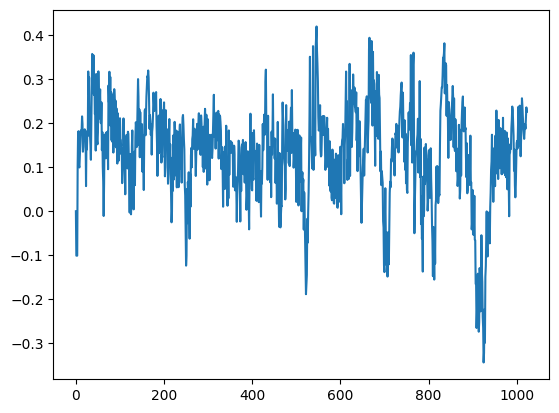

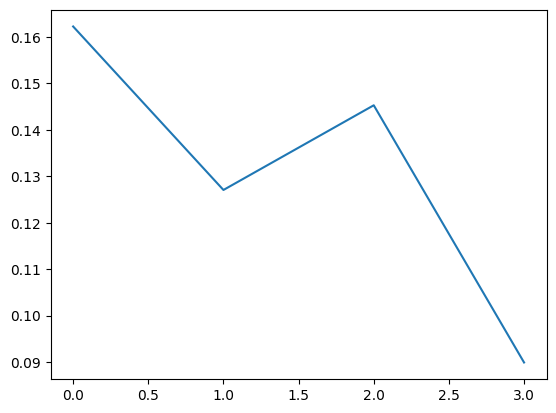

[PPO] Epoch 0: Loss=2.7249, Policy=0.0000, Value=5.6227
[PPO] Epoch 10: Loss=1.7640, Policy=0.0001, Value=3.7008
[PPO] Epoch 20: Loss=1.1265, Policy=-0.0014, Value=2.4300
[PPO] Epoch 30: Loss=1.0955, Policy=-0.0028, Value=2.3719
[PPO] Epoch 40: Loss=1.0842, Policy=-0.0035, Value=2.3511
[PPO] Epoch 50: Loss=1.0755, Policy=-0.0036, Value=2.3337
[PPO] Epoch 60: Loss=1.0641, Policy=-0.0038, Value=2.3114
[PPO] Epoch 70: Loss=1.0550, Policy=-0.0051, Value=2.2958
[PPO] Epoch 80: Loss=1.0500, Policy=-0.0044, Value=2.2843
[PPO] Epoch 90: Loss=1.0457, Policy=-0.0047, Value=2.2764
Approx KL Learned: 0.010816610418260098
Update 2/20 — steps: 1024


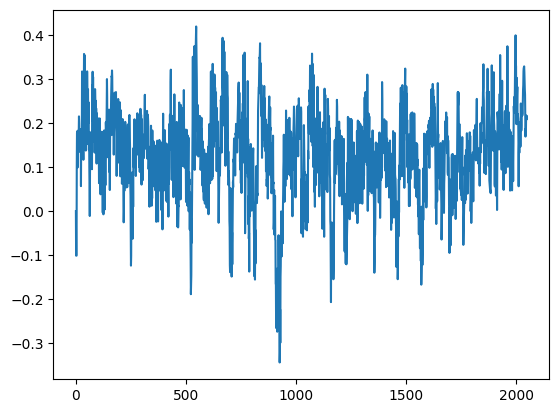

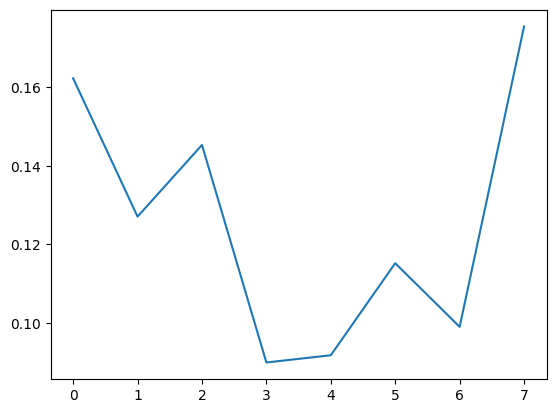

[PPO] Epoch 0: Loss=2.2890, Policy=0.0000, Value=4.7533
[PPO] Epoch 10: Loss=2.0151, Policy=0.0011, Value=4.2036
[PPO] Epoch 20: Loss=1.9987, Policy=-0.0074, Value=4.1859
[PPO] Epoch 30: Loss=1.9826, Policy=-0.0075, Value=4.1551
[PPO] Epoch 40: Loss=1.9764, Policy=-0.0086, Value=4.1444
[PPO] Epoch 50: Loss=1.9722, Policy=-0.0100, Value=4.1388
[PPO] Epoch 60: Loss=1.9680, Policy=-0.0121, Value=4.1339
[PPO] Epoch 70: Loss=1.9654, Policy=-0.0126, Value=4.1296
[PPO] Epoch 80: Loss=1.9635, Policy=-0.0129, Value=4.1263
[PPO] Epoch 90: Loss=1.9617, Policy=-0.0130, Value=4.1230
Approx KL Learned: 0.004575357772409916
Update 3/20 — steps: 1024


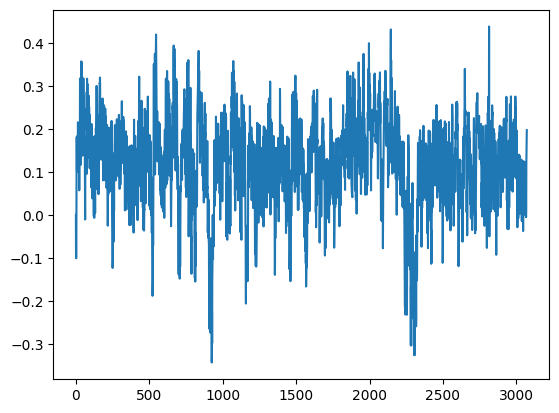

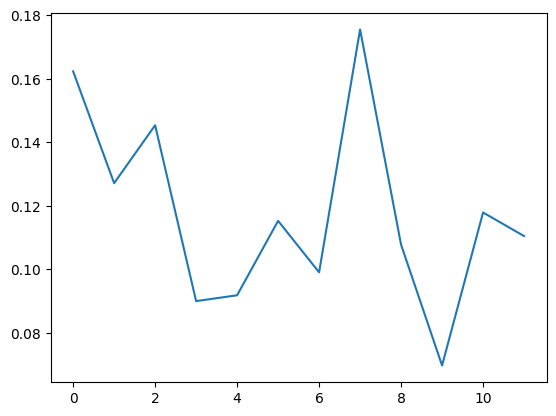

[PPO] Epoch 0: Loss=3.5435, Policy=-0.0000, Value=7.2607
[PPO] Epoch 10: Loss=2.7942, Policy=-0.0012, Value=5.7644
[PPO] Epoch 20: Loss=2.3898, Policy=-0.0032, Value=4.9593
[PPO] Epoch 30: Loss=2.3574, Policy=-0.0065, Value=4.8965
[PPO] Epoch 40: Loss=2.3483, Policy=-0.0126, Value=4.8910
[PPO] Epoch 50: Loss=2.3460, Policy=-0.0131, Value=4.8889
[PPO] Epoch 60: Loss=2.3387, Policy=-0.0155, Value=4.8773
[PPO] Epoch 70: Loss=2.3325, Policy=-0.0156, Value=4.8667
[PPO] Epoch 80: Loss=2.3229, Policy=-0.0178, Value=4.8518
[PPO] Epoch 90: Loss=2.3046, Policy=-0.0184, Value=4.8168
Approx KL Learned: 0.020761040970683098
Update 4/20 — steps: 1024


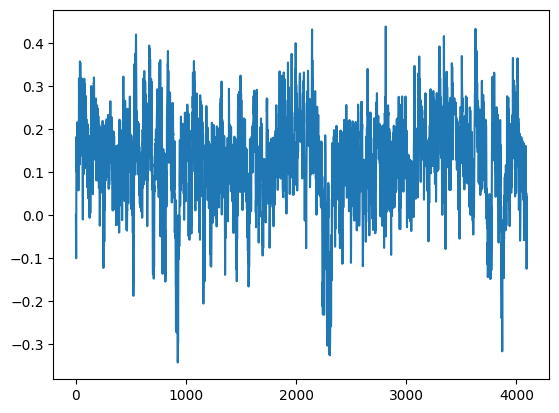

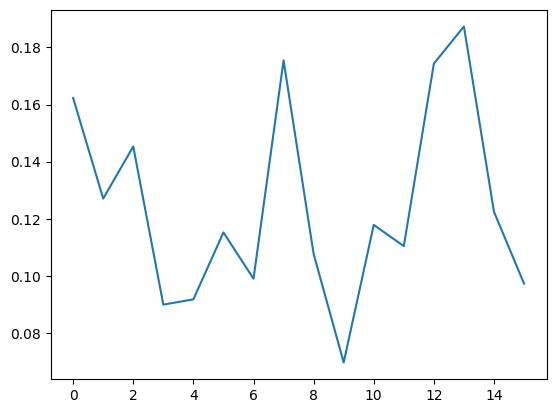

[PPO] Epoch 0: Loss=3.5400, Policy=0.0000, Value=7.2516
[PPO] Epoch 10: Loss=2.6671, Policy=-0.0005, Value=5.5073
[PPO] Epoch 20: Loss=2.2174, Policy=-0.0015, Value=4.6112
[PPO] Epoch 30: Loss=2.2294, Policy=-0.0020, Value=4.6362
[PPO] Epoch 40: Loss=2.2166, Policy=-0.0027, Value=4.6120
[PPO] Epoch 50: Loss=2.2092, Policy=-0.0032, Value=4.5978
[PPO] Epoch 60: Loss=2.2055, Policy=-0.0050, Value=4.5930
[PPO] Epoch 70: Loss=2.2021, Policy=-0.0055, Value=4.5877
[PPO] Epoch 80: Loss=2.1957, Policy=-0.0098, Value=4.5836
[PPO] Epoch 90: Loss=2.1916, Policy=-0.0123, Value=4.5800
Approx KL Learned: 0.00847163237631321
Update 5/20 — steps: 1024


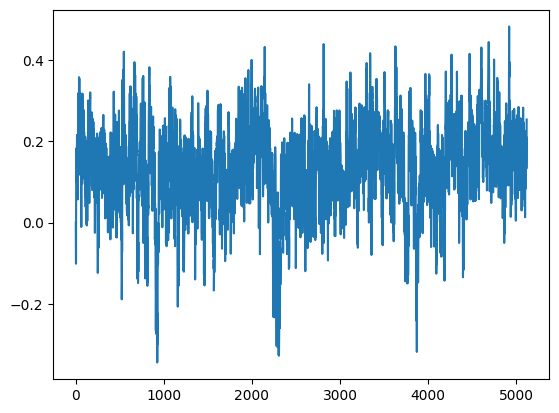

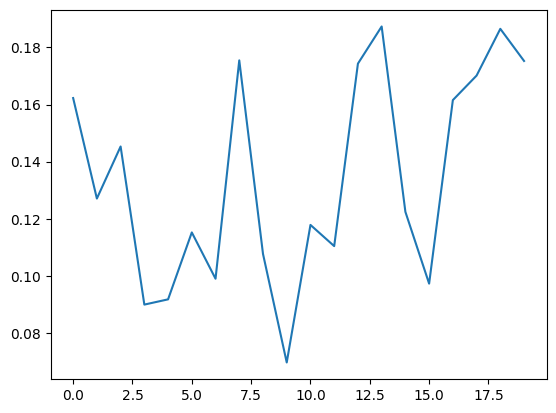

[PPO] Epoch 0: Loss=3.1253, Policy=-0.0000, Value=6.4212
[PPO] Epoch 10: Loss=2.9053, Policy=0.0008, Value=5.9804
[PPO] Epoch 20: Loss=2.8376, Policy=-0.0084, Value=5.8605
[PPO] Epoch 30: Loss=2.8186, Policy=-0.0127, Value=5.8344
[PPO] Epoch 40: Loss=2.8190, Policy=-0.0129, Value=5.8324
[PPO] Epoch 50: Loss=2.8113, Policy=-0.0188, Value=5.8302
[PPO] Epoch 60: Loss=2.8069, Policy=-0.0223, Value=5.8280
[PPO] Epoch 70: Loss=2.8023, Policy=-0.0256, Value=5.8255
[PPO] Epoch 80: Loss=2.8066, Policy=-0.0203, Value=5.8229
[PPO] Epoch 90: Loss=2.7989, Policy=-0.0267, Value=5.8209
Approx KL Learned: 0.007457375060766935
Update 6/20 — steps: 1024


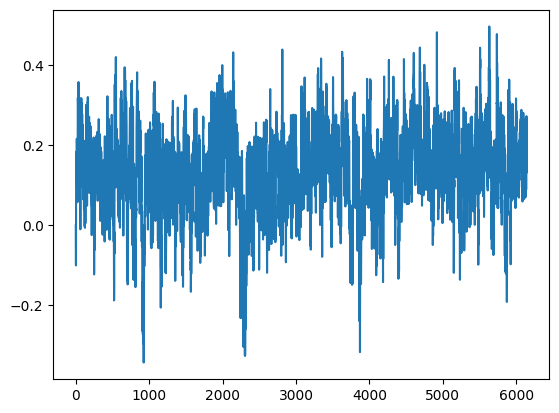

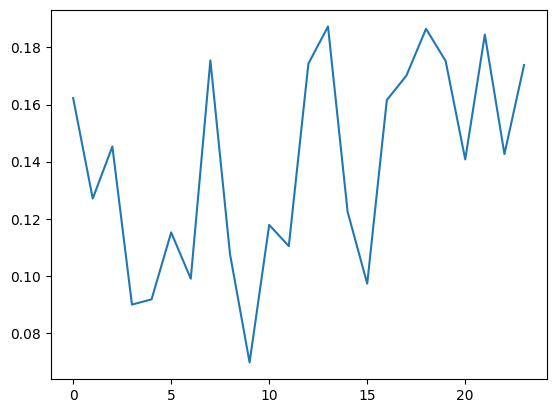

[PPO] Epoch 0: Loss=3.5514, Policy=0.0000, Value=7.2738
[PPO] Epoch 10: Loss=3.5367, Policy=-0.0151, Value=7.2725
[PPO] Epoch 20: Loss=3.5316, Policy=-0.0194, Value=7.2716
[PPO] Epoch 30: Loss=3.5301, Policy=-0.0199, Value=7.2708
[PPO] Epoch 40: Loss=3.5254, Policy=-0.0243, Value=7.2701
[PPO] Epoch 50: Loss=3.5229, Policy=-0.0268, Value=7.2693
[PPO] Epoch 60: Loss=3.5194, Policy=-0.0297, Value=7.2685
[PPO] Epoch 70: Loss=3.5206, Policy=-0.0279, Value=7.2679
[PPO] Epoch 80: Loss=3.5184, Policy=-0.0301, Value=7.2673
[PPO] Epoch 90: Loss=3.5192, Policy=-0.0288, Value=7.2668
Approx KL Learned: 0.008799714036285877
Update 7/20 — steps: 1024


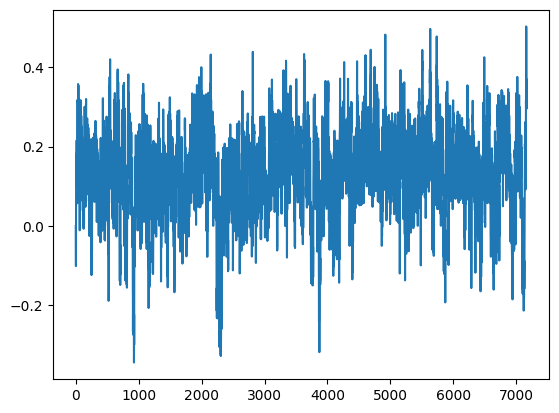

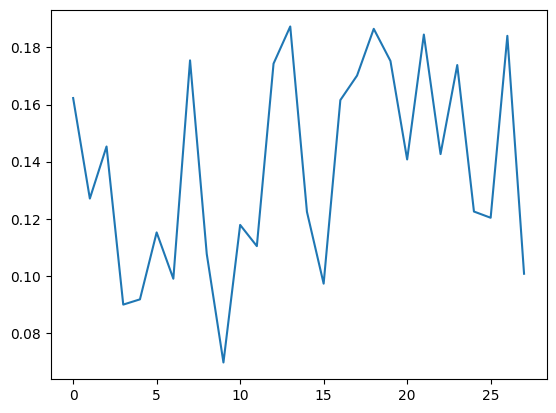

[PPO] Epoch 0: Loss=2.5995, Policy=0.0000, Value=5.3702
[PPO] Epoch 10: Loss=2.5802, Policy=-0.0115, Value=5.3539
[PPO] Epoch 20: Loss=2.5718, Policy=-0.0178, Value=5.3499
[PPO] Epoch 30: Loss=2.5704, Policy=-0.0187, Value=5.3480
[PPO] Epoch 40: Loss=2.5668, Policy=-0.0229, Value=5.3470
[PPO] Epoch 50: Loss=2.5641, Policy=-0.0251, Value=5.3460
[PPO] Epoch 60: Loss=2.5627, Policy=-0.0255, Value=5.3451
[PPO] Epoch 70: Loss=2.5587, Policy=-0.0292, Value=5.3441
[PPO] Epoch 80: Loss=2.5566, Policy=-0.0307, Value=5.3427
[PPO] Epoch 90: Loss=2.5502, Policy=-0.0333, Value=5.3352
Approx KL Learned: 0.013239377178251743
Update 8/20 — steps: 1024


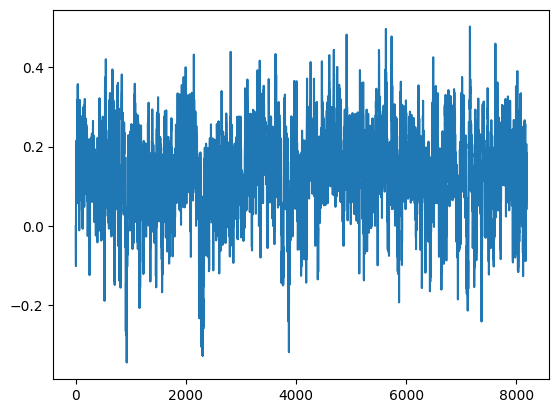

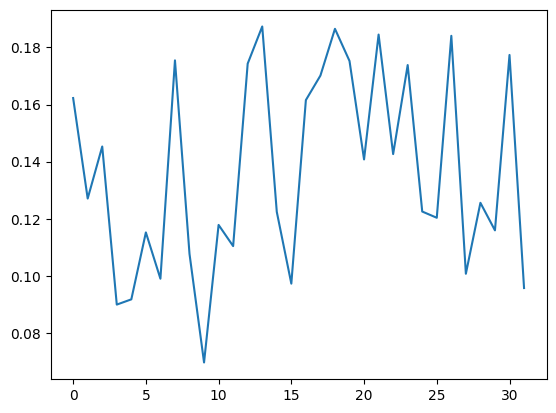

[PPO] Epoch 0: Loss=3.2544, Policy=0.0000, Value=6.6789
[PPO] Epoch 10: Loss=3.0124, Policy=-0.0038, Value=6.2021
[PPO] Epoch 20: Loss=2.9601, Policy=-0.0116, Value=6.1131
[PPO] Epoch 30: Loss=2.9427, Policy=-0.0151, Value=6.0849
[PPO] Epoch 40: Loss=2.9419, Policy=-0.0125, Value=6.0779
[PPO] Epoch 50: Loss=2.9335, Policy=-0.0178, Value=6.0710
[PPO] Epoch 60: Loss=2.9338, Policy=-0.0150, Value=6.0653
[PPO] Epoch 70: Loss=2.9325, Policy=-0.0126, Value=6.0586
[PPO] Epoch 80: Loss=2.9161, Policy=-0.0254, Value=6.0496
[PPO] Epoch 90: Loss=2.9055, Policy=-0.0301, Value=6.0382
Approx KL Learned: 0.0023523708805441856
Update 9/20 — steps: 1024


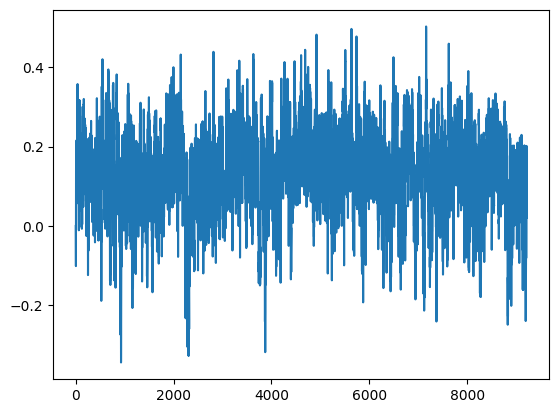

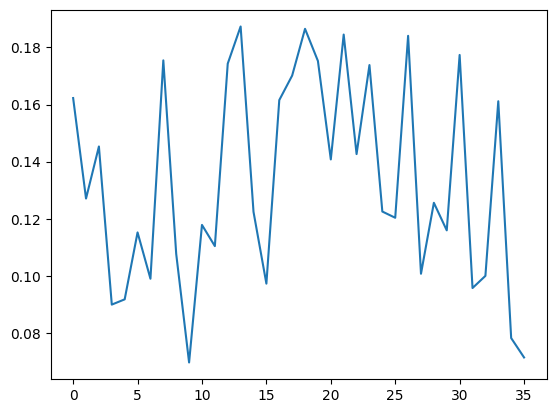

[PPO] Epoch 0: Loss=3.1354, Policy=0.0000, Value=6.4335
[PPO] Epoch 10: Loss=2.7945, Policy=-0.0096, Value=5.7696
[PPO] Epoch 20: Loss=2.6887, Policy=-0.0170, Value=5.5729
[PPO] Epoch 30: Loss=2.6687, Policy=-0.0210, Value=5.5410
[PPO] Epoch 40: Loss=2.6557, Policy=-0.0227, Value=5.5188
[PPO] Epoch 50: Loss=2.6511, Policy=-0.0245, Value=5.5130
[PPO] Epoch 60: Loss=2.6513, Policy=-0.0219, Value=5.5067
[PPO] Epoch 70: Loss=2.6458, Policy=-0.0245, Value=5.5000
[PPO] Epoch 80: Loss=2.6508, Policy=-0.0158, Value=5.4931
[PPO] Epoch 90: Loss=2.6359, Policy=-0.0270, Value=5.4865
Approx KL Learned: 0.018871933221817017
Update 10/20 — steps: 1024


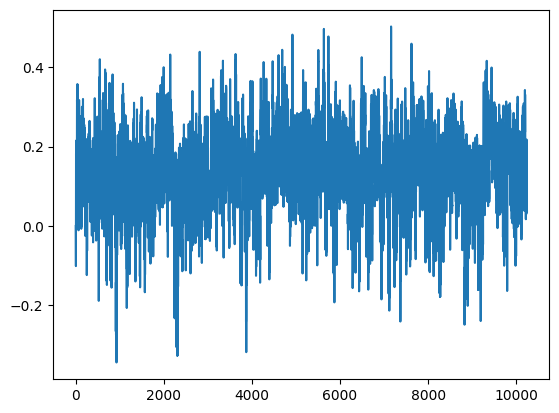

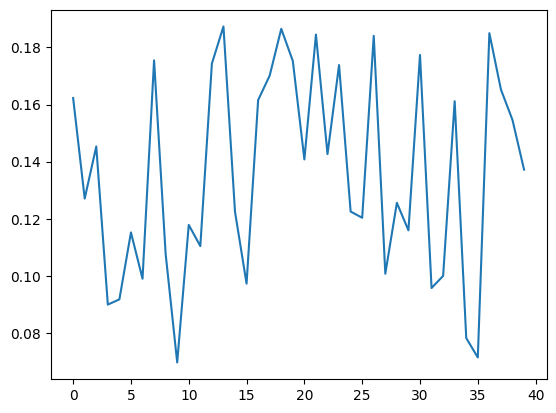

[PPO] Epoch 0: Loss=2.7477, Policy=0.0000, Value=5.6563
[PPO] Epoch 10: Loss=2.6801, Policy=-0.0053, Value=5.5313
[PPO] Epoch 20: Loss=2.6622, Policy=-0.0193, Value=5.5212
[PPO] Epoch 30: Loss=2.6483, Policy=-0.0263, Value=5.5069
[PPO] Epoch 40: Loss=2.6363, Policy=-0.0311, Value=5.4929
[PPO] Epoch 50: Loss=2.6311, Policy=-0.0326, Value=5.4852
[PPO] Epoch 60: Loss=2.6022, Policy=-0.0271, Value=5.4166
[PPO] Epoch 70: Loss=2.5619, Policy=-0.0359, Value=5.3537
[PPO] Epoch 80: Loss=2.5494, Policy=-0.0380, Value=5.3328
[PPO] Epoch 90: Loss=2.5576, Policy=-0.0392, Value=5.3515
Approx KL Learned: 0.03060813434422016
Update 11/20 — steps: 1024


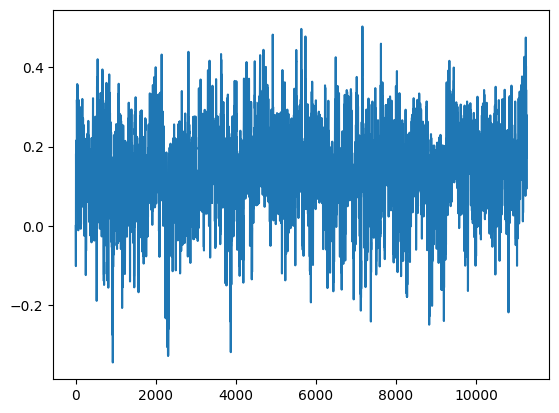

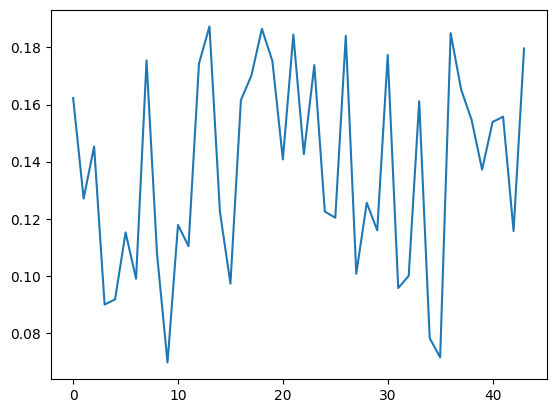

[PPO] Epoch 0: Loss=2.9187, Policy=-0.0000, Value=5.9963
[PPO] Epoch 10: Loss=2.8925, Policy=-0.0080, Value=5.9585
[PPO] Epoch 20: Loss=2.8552, Policy=-0.0133, Value=5.8963
[PPO] Epoch 30: Loss=2.8463, Policy=-0.0141, Value=5.8787
[PPO] Epoch 40: Loss=2.8306, Policy=-0.0221, Value=5.8643
[PPO] Epoch 50: Loss=2.8205, Policy=-0.0232, Value=5.8466
[PPO] Epoch 60: Loss=2.8106, Policy=-0.0256, Value=5.8293
[PPO] Epoch 70: Loss=2.8201, Policy=-0.0054, Value=5.8123
[PPO] Epoch 80: Loss=2.7937, Policy=-0.0259, Value=5.7994
[PPO] Epoch 90: Loss=2.7886, Policy=-0.0210, Value=5.7825
Approx KL Learned: 0.02213718555867672
Update 12/20 — steps: 1024


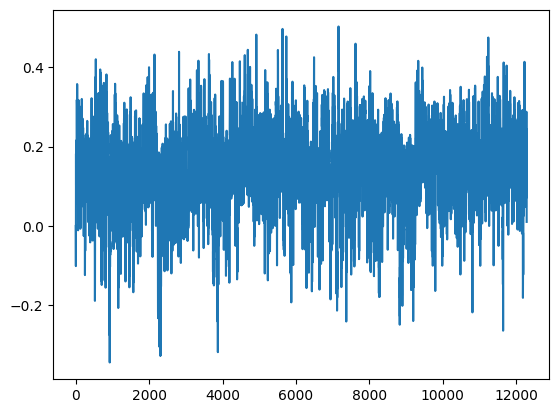

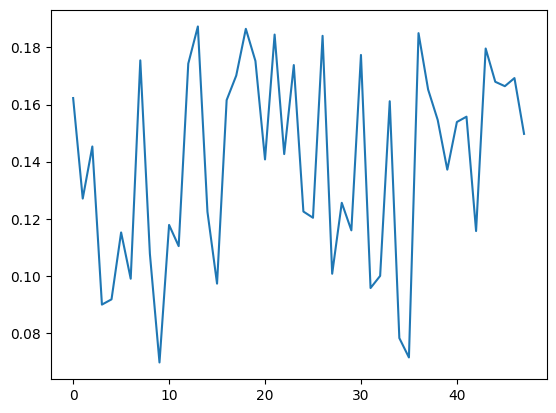

[PPO] Epoch 0: Loss=3.7050, Policy=0.0000, Value=7.5663
[PPO] Epoch 10: Loss=3.5195, Policy=-0.0079, Value=7.2097
[PPO] Epoch 20: Loss=3.4832, Policy=-0.0154, Value=7.1471
[PPO] Epoch 30: Loss=3.4683, Policy=-0.0230, Value=7.1345
[PPO] Epoch 40: Loss=3.4571, Policy=-0.0217, Value=7.1110
[PPO] Epoch 50: Loss=3.4532, Policy=-0.0120, Value=7.0866
[PPO] Epoch 60: Loss=3.4477, Policy=-0.0176, Value=7.0789
[PPO] Epoch 70: Loss=3.4331, Policy=-0.0222, Value=7.0596
[PPO] Epoch 80: Loss=3.4212, Policy=-0.0202, Value=7.0349
[PPO] Epoch 90: Loss=3.4059, Policy=-0.0183, Value=7.0048
Approx KL Learned: 0.018357915803790092
Update 13/20 — steps: 1024


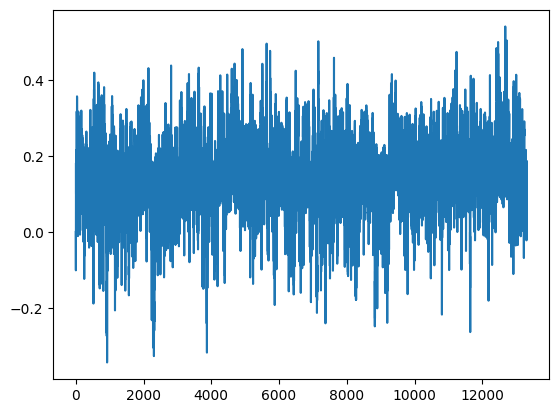

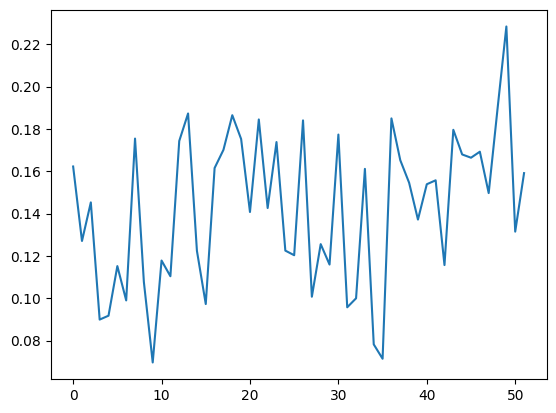

[PPO] Epoch 0: Loss=3.1995, Policy=0.0000, Value=6.5513
[PPO] Epoch 10: Loss=3.1348, Policy=-0.0117, Value=6.4497
[PPO] Epoch 20: Loss=3.1005, Policy=-0.0227, Value=6.4027
[PPO] Epoch 30: Loss=3.0129, Policy=-0.0305, Value=6.2418
[PPO] Epoch 40: Loss=2.9547, Policy=-0.0332, Value=6.1299
[PPO] Epoch 50: Loss=2.7635, Policy=-0.0366, Value=5.7548
[PPO] Epoch 60: Loss=2.5774, Policy=-0.0368, Value=5.3828
[PPO] Epoch 70: Loss=2.5691, Policy=-0.0379, Value=5.3685
[PPO] Epoch 80: Loss=2.5785, Policy=-0.0386, Value=5.3883
[PPO] Epoch 90: Loss=2.6295, Policy=-0.0375, Value=5.4887
Approx KL Learned: 0.008183714933693409
Update 14/20 — steps: 1024


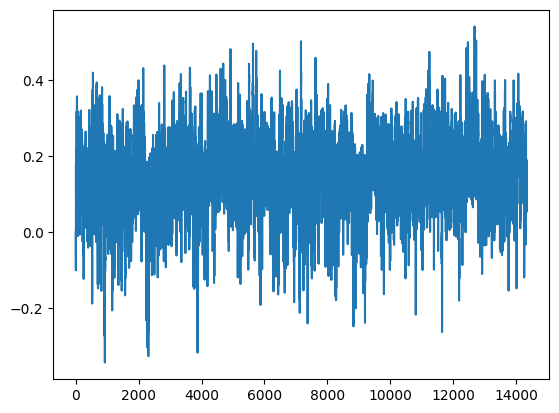

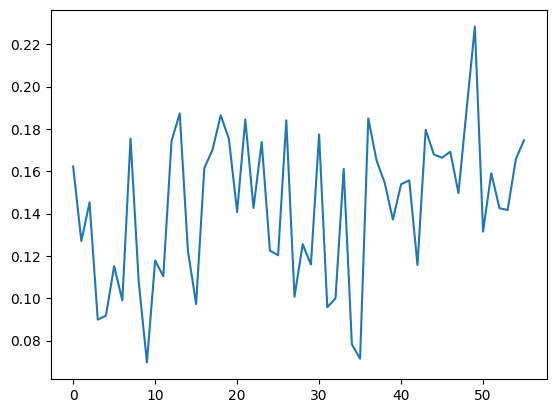

[PPO] Epoch 0: Loss=3.1259, Policy=0.0000, Value=6.4064
[PPO] Epoch 10: Loss=2.9022, Policy=-0.0085, Value=5.9747
[PPO] Epoch 20: Loss=3.3985, Policy=-0.0160, Value=6.9816
[PPO] Epoch 30: Loss=3.0986, Policy=-0.0191, Value=6.3886
[PPO] Epoch 40: Loss=3.0124, Policy=-0.0214, Value=6.2207
[PPO] Epoch 50: Loss=2.7549, Policy=-0.0239, Value=5.7104
[PPO] Epoch 60: Loss=2.5885, Policy=-0.0260, Value=5.3818
[PPO] Epoch 70: Loss=2.6965, Policy=-0.0277, Value=5.6012
[PPO] Epoch 80: Loss=2.2959, Policy=-0.0287, Value=4.8021
[PPO] Epoch 90: Loss=2.2343, Policy=-0.0295, Value=4.6802
Approx KL Learned: 0.008916002698242664
Update 15/20 — steps: 1024


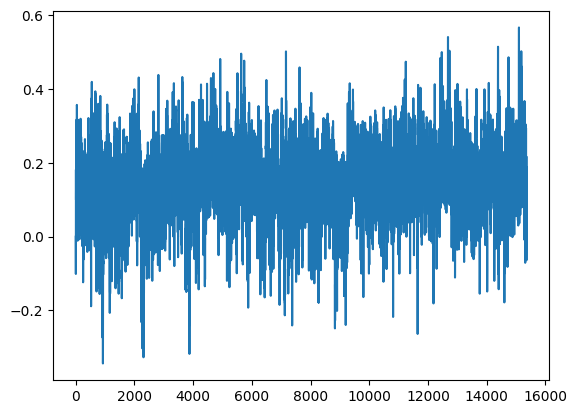

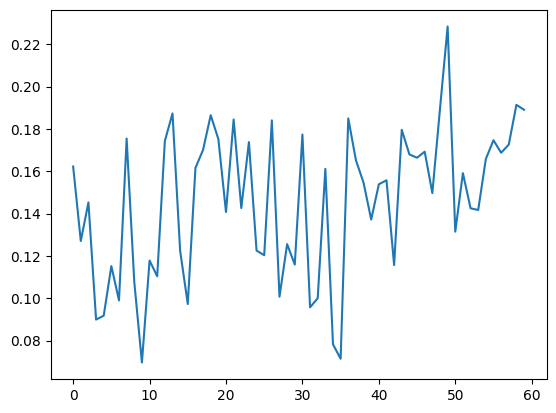

[PPO] Epoch 0: Loss=2.4487, Policy=-0.0000, Value=5.0495
[PPO] Epoch 10: Loss=2.7905, Policy=-0.0013, Value=5.7391
[PPO] Epoch 20: Loss=2.7384, Policy=0.0226, Value=5.5909
[PPO] Epoch 30: Loss=2.8666, Policy=0.0118, Value=5.8698
[PPO] Epoch 40: Loss=2.3121, Policy=-0.0041, Value=4.7917
[PPO] Epoch 50: Loss=2.8829, Policy=-0.0187, Value=5.9585
[PPO] Epoch 60: Loss=2.2501, Policy=-0.0172, Value=4.6883
[PPO] Epoch 70: Loss=2.2009, Policy=-0.0197, Value=4.5951
[PPO] Epoch 80: Loss=3.4129, Policy=-0.0232, Value=7.0281
[PPO] Epoch 90: Loss=2.1546, Policy=-0.0235, Value=4.5129
Approx KL Learned: 0.0022074971348047256
Update 16/20 — steps: 1024


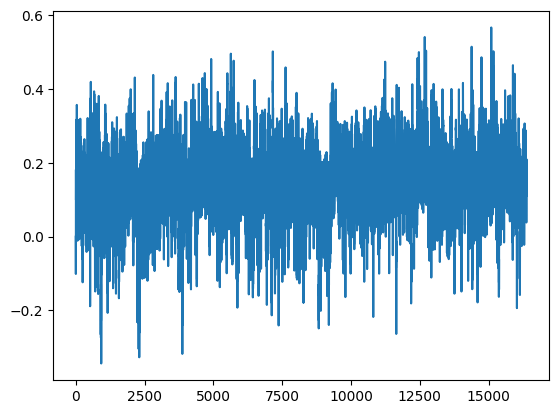

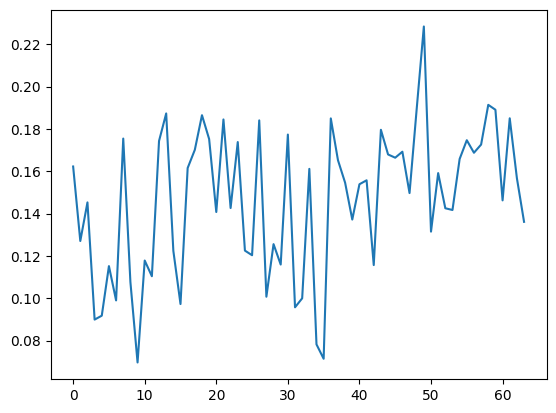

[PPO] Epoch 0: Loss=1.8606, Policy=0.0000, Value=3.8776
[PPO] Epoch 10: Loss=1.7758, Policy=0.0004, Value=3.7109
[PPO] Epoch 20: Loss=1.9829, Policy=0.0207, Value=4.0748
[PPO] Epoch 30: Loss=3.0067, Policy=0.0119, Value=6.1480
[PPO] Epoch 40: Loss=2.5918, Policy=0.0203, Value=5.3048
[PPO] Epoch 50: Loss=2.0193, Policy=0.0040, Value=4.1921
[PPO] Epoch 60: Loss=2.3124, Policy=0.0033, Value=4.7778
[PPO] Epoch 70: Loss=1.8104, Policy=-0.0115, Value=3.8038
[PPO] Epoch 80: Loss=1.6484, Policy=0.0043, Value=3.4502
[PPO] Epoch 90: Loss=2.2685, Policy=0.0020, Value=4.6953
Approx KL Learned: 0.014413807541131973
Update 17/20 — steps: 1024


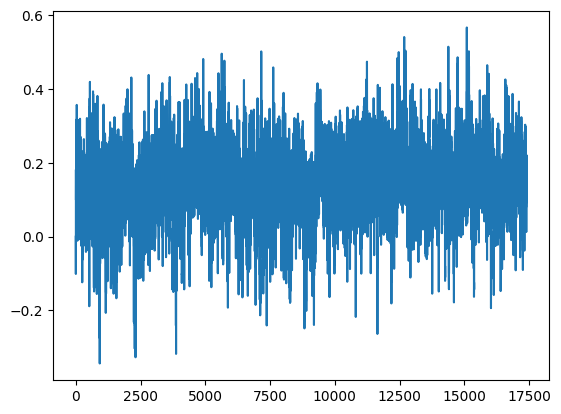

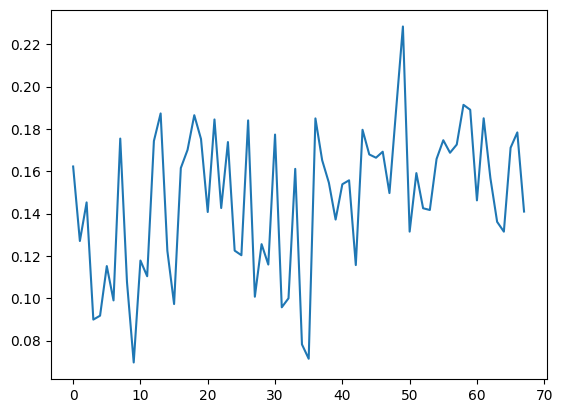

[PPO] Epoch 0: Loss=2.1564, Policy=-0.0000, Value=4.4725
[PPO] Epoch 10: Loss=3.0497, Policy=-0.0034, Value=6.2661
[PPO] Epoch 20: Loss=2.7146, Policy=-0.0109, Value=5.6117
[PPO] Epoch 30: Loss=2.3877, Policy=-0.0144, Value=4.9649
[PPO] Epoch 40: Loss=2.1725, Policy=-0.0186, Value=4.5426
[PPO] Epoch 50: Loss=2.1383, Policy=-0.0215, Value=4.4791
[PPO] Epoch 60: Loss=2.1665, Policy=-0.0239, Value=4.5403
[PPO] Epoch 70: Loss=2.0453, Policy=-0.0259, Value=4.3014
[PPO] Epoch 80: Loss=1.9843, Policy=-0.0270, Value=4.1820
[PPO] Epoch 90: Loss=1.9870, Policy=-0.0277, Value=4.1886
Approx KL Learned: 0.008011620491743088
Update 18/20 — steps: 1024


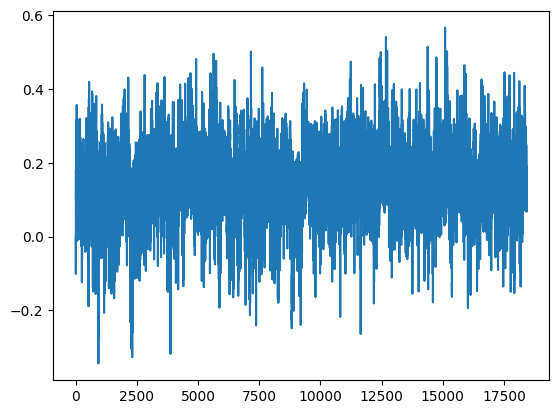

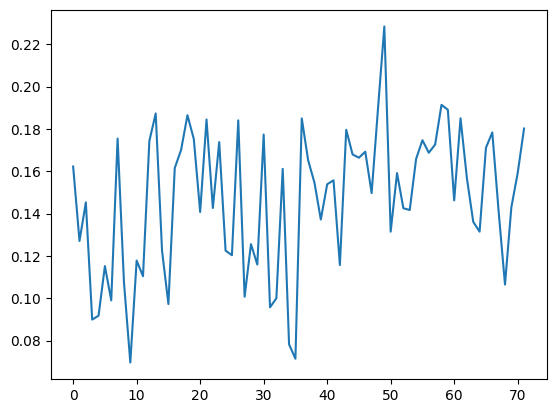

[PPO] Epoch 0: Loss=2.2439, Policy=-0.0000, Value=4.6445
[PPO] Epoch 10: Loss=2.1693, Policy=-0.0039, Value=4.5037
[PPO] Epoch 20: Loss=2.4137, Policy=-0.0084, Value=5.0021
[PPO] Epoch 30: Loss=1.9701, Policy=-0.0095, Value=4.1179
[PPO] Epoch 40: Loss=2.0641, Policy=-0.0104, Value=4.3080
[PPO] Epoch 50: Loss=1.8641, Policy=-0.0109, Value=3.9085
[PPO] Epoch 60: Loss=1.8236, Policy=-0.0152, Value=3.8367
[PPO] Epoch 70: Loss=1.9032, Policy=-0.0095, Value=3.9835
[PPO] Epoch 80: Loss=1.7024, Policy=-0.0048, Value=3.5707
[PPO] Epoch 90: Loss=1.8100, Policy=-0.0151, Value=3.8085
Approx KL Learned: 0.0053282491862773895
Update 19/20 — steps: 1024


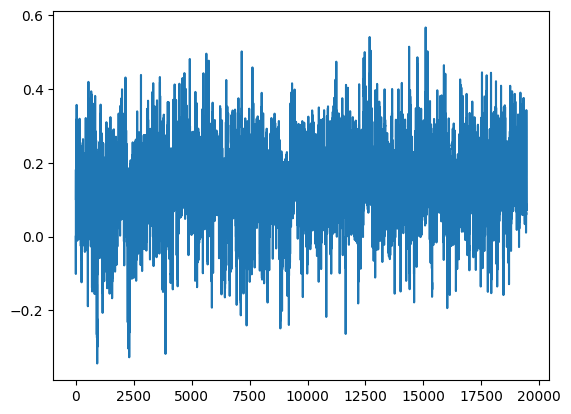

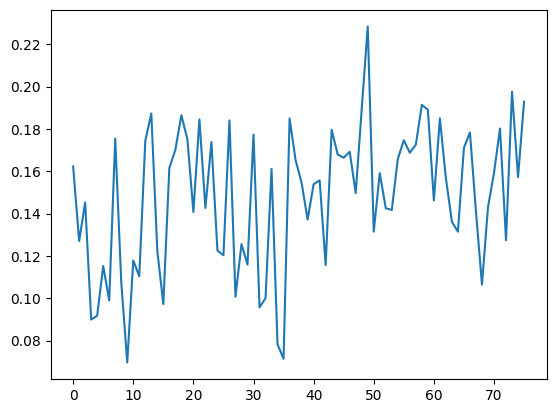

[PPO] Epoch 0: Loss=2.6805, Policy=-0.0000, Value=5.5236
[PPO] Epoch 10: Loss=2.4063, Policy=-0.0016, Value=4.9774
[PPO] Epoch 20: Loss=2.2519, Policy=-0.0107, Value=4.6886
[PPO] Epoch 30: Loss=2.1853, Policy=-0.0077, Value=4.5516
[PPO] Epoch 40: Loss=2.4917, Policy=-0.0140, Value=5.1750
[PPO] Epoch 50: Loss=2.5677, Policy=-0.0158, Value=5.3303
[PPO] Epoch 60: Loss=2.4032, Policy=-0.0169, Value=5.0047
[PPO] Epoch 70: Loss=2.1000, Policy=-0.0182, Value=4.4005
[PPO] Epoch 80: Loss=2.3013, Policy=-0.0193, Value=4.8052
[PPO] Epoch 90: Loss=2.4313, Policy=-0.0198, Value=5.0658
Approx KL Learned: 0.009187381714582443
Update 20/20 — steps: 1024


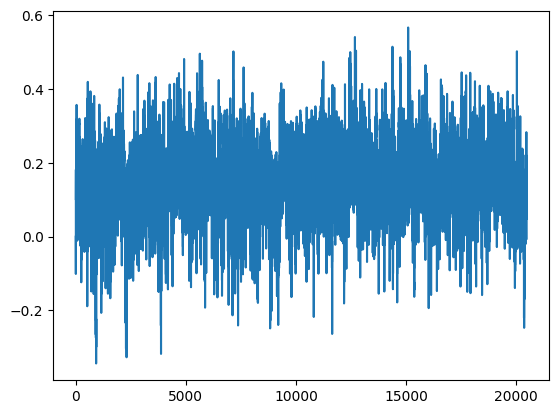

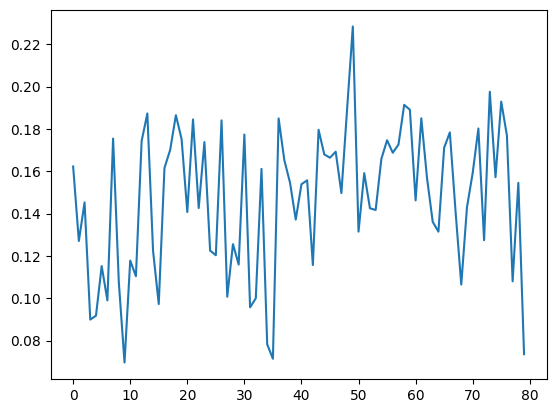

In [10]:
ENTROPY_COEF = 0.08

ppo = PPO(ENTROPY_COEF)
encoder = FrozenResNetEncoder()
actor = LSTMActor(FEAT_DIM, NUM_ACTIONS)
critic = LSTMCritic(FEAT_DIM)
clip_novelty = CLIPNovelty()
clip_env = ClipEnv(clip_novelty)
clip_actor_critic = ActorCritic(encoder, actor, critic)
buf, rewards = train(controller, ppo, clip_env, clip_actor_critic, 20)

In [12]:
from rl import save_actor_critic
save_actor_critic(clip_actor_critic, "clip_actor_critic_checkpoint_lstm.pt")

[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_lstm.pt


[PPO] Epoch 0: Loss=1.2858, Policy=0.0059, Value=2.5910
[PPO] Epoch 10: Loss=0.2765, Policy=-0.0442, Value=0.6738
[PPO] Epoch 20: Loss=0.0617, Policy=-0.0804, Value=0.3150
[PPO] Epoch 30: Loss=-0.0258, Policy=-0.1009, Value=0.1806
[PPO] Epoch 40: Loss=-0.0717, Policy=-0.1207, Value=0.1275
[PPO] Epoch 50: Loss=-0.0821, Policy=-0.1289, Value=0.1236
[PPO] Epoch 60: Loss=-0.1011, Policy=-0.1256, Value=0.0775
[PPO] Epoch 70: Loss=-0.1128, Policy=-0.1377, Value=0.0791
[PPO] Epoch 80: Loss=-0.1239, Policy=-0.1430, Value=0.0674
[PPO] Epoch 90: Loss=-0.1166, Policy=-0.1426, Value=0.0811
Approx KL Learned: 0.1704757958650589
Update 1/10 — steps: 1024


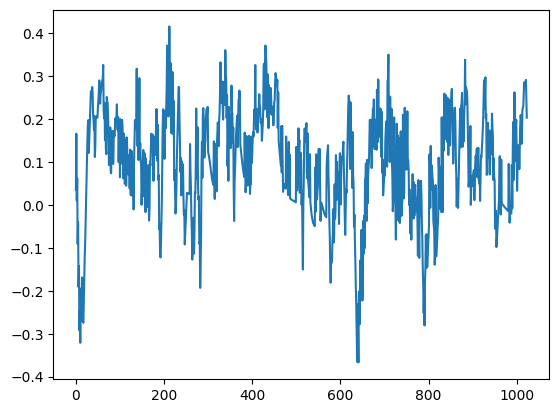

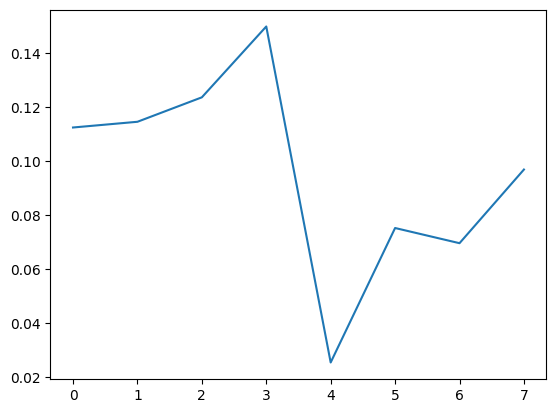

[PPO] Epoch 0: Loss=12.0742, Policy=0.0221, Value=24.1344
[PPO] Epoch 10: Loss=5.8584, Policy=0.0236, Value=11.6995
[PPO] Epoch 20: Loss=2.9851, Policy=0.0104, Value=5.9797
[PPO] Epoch 30: Loss=1.3546, Policy=-0.0115, Value=2.7627
[PPO] Epoch 40: Loss=1.3944, Policy=-0.0374, Value=2.8948
[PPO] Epoch 50: Loss=0.4153, Policy=-0.0570, Value=0.9755
[PPO] Epoch 60: Loss=0.1706, Policy=-0.0800, Value=0.5302
[PPO] Epoch 70: Loss=0.1770, Policy=-0.0862, Value=0.5552
[PPO] Epoch 80: Loss=0.1047, Policy=-0.0993, Value=0.4370
[PPO] Epoch 90: Loss=0.1385, Policy=-0.0751, Value=0.4529
Approx KL Learned: 0.07761117070913315
Update 2/10 — steps: 1024


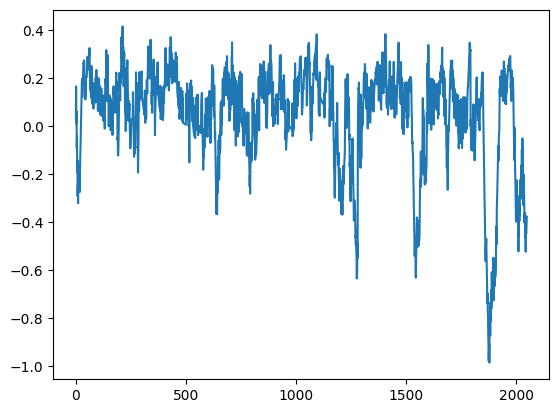

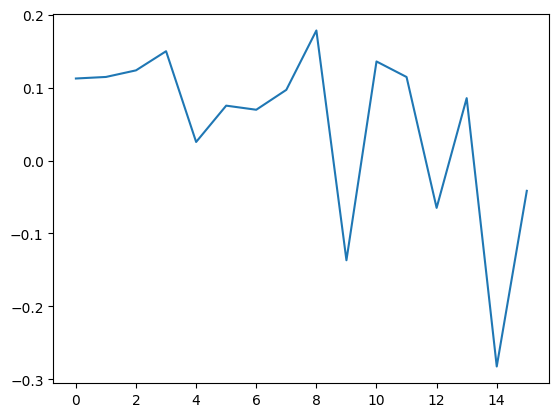

[PPO] Epoch 0: Loss=2.4242, Policy=0.0270, Value=4.8247
[PPO] Epoch 10: Loss=0.6578, Policy=-0.0162, Value=1.3777
[PPO] Epoch 20: Loss=0.2129, Policy=-0.0609, Value=0.5777
[PPO] Epoch 30: Loss=0.0331, Policy=-0.0882, Value=0.2719
[PPO] Epoch 40: Loss=-0.0082, Policy=-0.1050, Value=0.2226
[PPO] Epoch 50: Loss=-0.0628, Policy=-0.1153, Value=0.1328
[PPO] Epoch 60: Loss=-0.0550, Policy=-0.1257, Value=0.1694
[PPO] Epoch 70: Loss=-0.0922, Policy=-0.1300, Value=0.1032
[PPO] Epoch 80: Loss=-0.1051, Policy=-0.1328, Value=0.0829
[PPO] Epoch 90: Loss=-0.0909, Policy=-0.1340, Value=0.1134
Approx KL Learned: 0.10161039233207703
Update 3/10 — steps: 1024


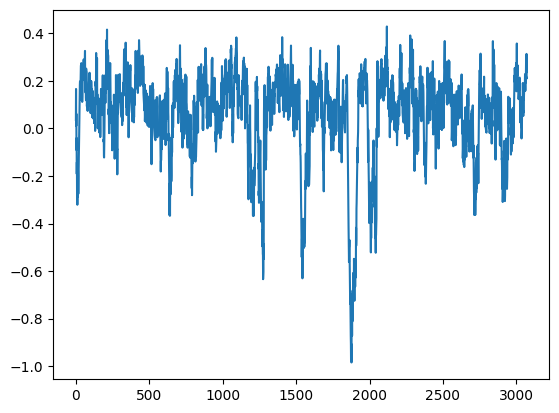

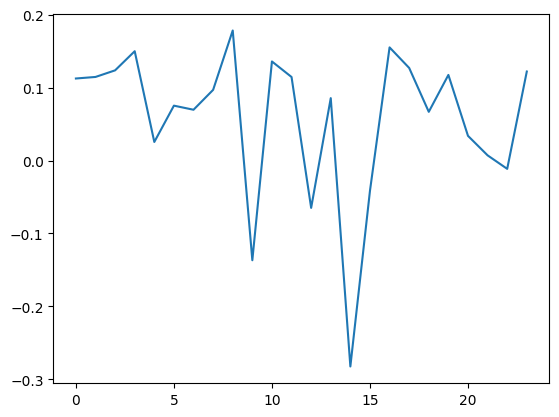

[PPO] Epoch 0: Loss=18.9210, Policy=0.0047, Value=37.8591
[PPO] Epoch 10: Loss=9.0605, Policy=0.0232, Value=18.1022
[PPO] Epoch 20: Loss=3.9055, Policy=-0.0074, Value=7.8528
[PPO] Epoch 30: Loss=1.2602, Policy=-0.0091, Value=2.5652
[PPO] Epoch 40: Loss=0.6229, Policy=-0.0422, Value=1.3576
[PPO] Epoch 50: Loss=0.2902, Policy=-0.0590, Value=0.7247
[PPO] Epoch 60: Loss=0.2087, Policy=-0.0732, Value=0.5899
[PPO] Epoch 70: Loss=0.2128, Policy=-0.0795, Value=0.6103
[PPO] Epoch 80: Loss=0.0872, Policy=-0.0930, Value=0.3857
[PPO] Epoch 90: Loss=0.0556, Policy=-0.0999, Value=0.3357
Approx KL Learned: 0.07021254301071167
Update 4/10 — steps: 1024


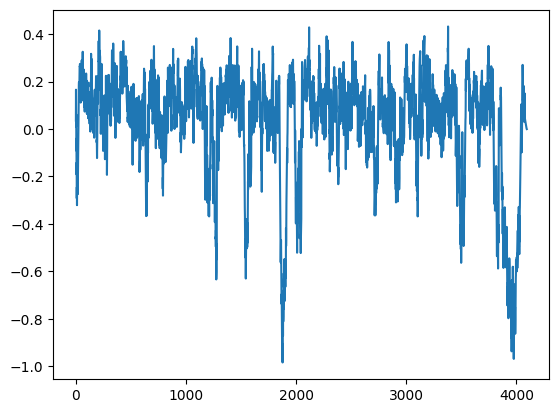

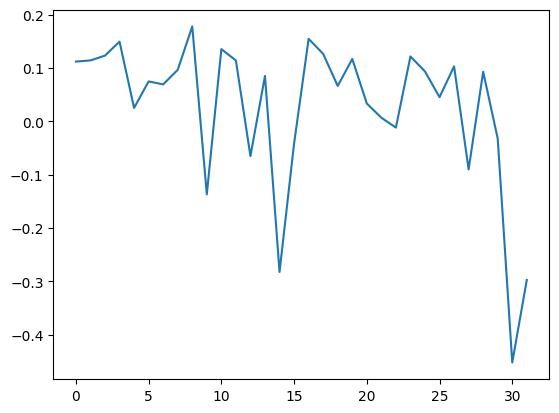

[PPO] Epoch 0: Loss=4.3842, Policy=0.0238, Value=8.7483
[PPO] Epoch 10: Loss=1.1913, Policy=0.0085, Value=2.3932
[PPO] Epoch 20: Loss=0.3813, Policy=-0.0240, Value=0.8392
[PPO] Epoch 30: Loss=0.1824, Policy=-0.0461, Value=0.4847
[PPO] Epoch 40: Loss=0.0978, Policy=-0.0615, Value=0.3452
[PPO] Epoch 50: Loss=0.0201, Policy=-0.0775, Value=0.2216
[PPO] Epoch 60: Loss=0.0147, Policy=-0.0887, Value=0.2332
[PPO] Epoch 70: Loss=0.0207, Policy=-0.0937, Value=0.2552
[PPO] Epoch 80: Loss=-0.0280, Policy=-0.1008, Value=0.1718
[PPO] Epoch 90: Loss=-0.0321, Policy=-0.1028, Value=0.1676
Approx KL Learned: 0.09212048351764679
Update 5/10 — steps: 1024


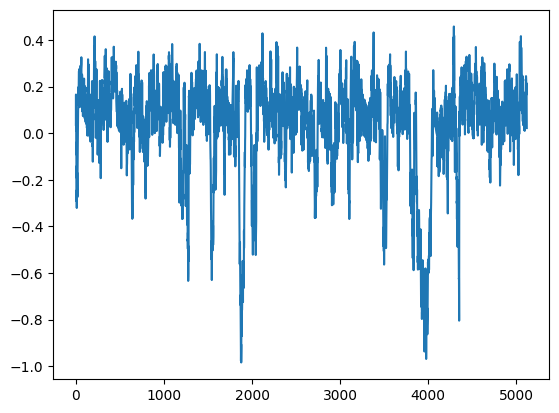

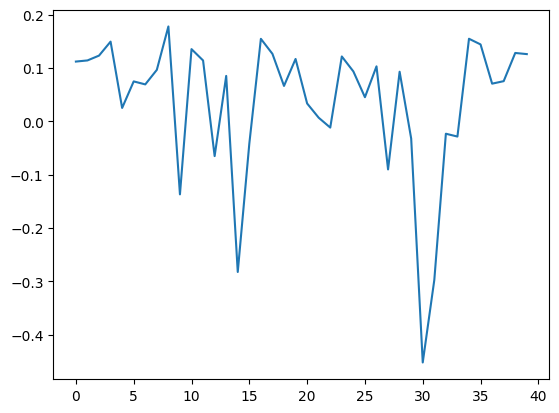

[PPO] Epoch 0: Loss=3.7799, Policy=0.0089, Value=7.5673
[PPO] Epoch 10: Loss=1.0809, Policy=-0.0219, Value=2.2316
[PPO] Epoch 20: Loss=0.3874, Policy=-0.0393, Value=0.8796
[PPO] Epoch 30: Loss=0.1744, Policy=-0.0651, Value=0.5043
[PPO] Epoch 40: Loss=0.0550, Policy=-0.0819, Value=0.2978
[PPO] Epoch 50: Loss=0.0125, Policy=-0.0870, Value=0.2228
[PPO] Epoch 60: Loss=0.0842, Policy=-0.0881, Value=0.3681
[PPO] Epoch 70: Loss=0.0353, Policy=-0.0957, Value=0.2851
[PPO] Epoch 80: Loss=-0.0278, Policy=-0.0998, Value=0.1674
[PPO] Epoch 90: Loss=0.0014, Policy=-0.1016, Value=0.2287
Approx KL Learned: 0.06852741539478302
Update 6/10 — steps: 1024


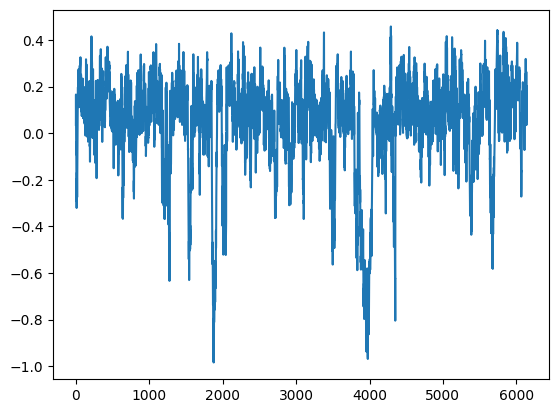

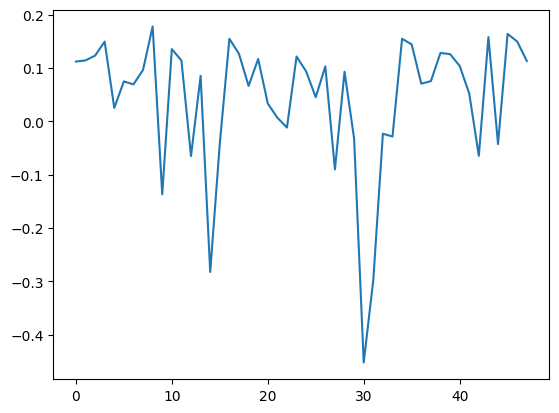

[PPO] Epoch 0: Loss=0.6670, Policy=0.0244, Value=1.3106
[PPO] Epoch 10: Loss=0.4733, Policy=-0.0217, Value=1.0148
[PPO] Epoch 20: Loss=0.1067, Policy=-0.0545, Value=0.3480
[PPO] Epoch 30: Loss=0.0386, Policy=-0.0672, Value=0.2359
[PPO] Epoch 40: Loss=-0.0287, Policy=-0.0936, Value=0.1551
[PPO] Epoch 50: Loss=-0.0498, Policy=-0.1059, Value=0.1364
[PPO] Epoch 60: Loss=-0.0253, Policy=-0.1120, Value=0.1978
[PPO] Epoch 70: Loss=-0.0622, Policy=-0.1097, Value=0.1198
[PPO] Epoch 80: Loss=-0.0560, Policy=-0.1229, Value=0.1575
[PPO] Epoch 90: Loss=-0.0936, Policy=-0.1252, Value=0.0872
Approx KL Learned: 0.23099187016487122
Update 7/10 — steps: 1024


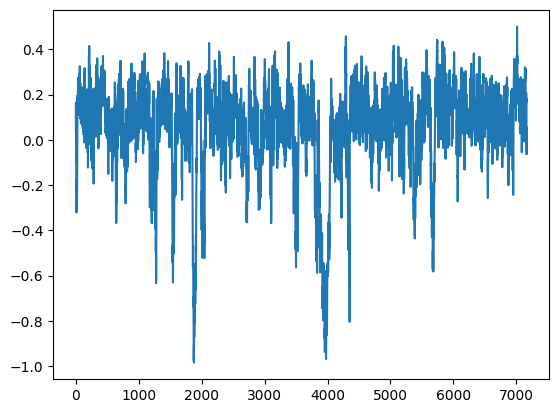

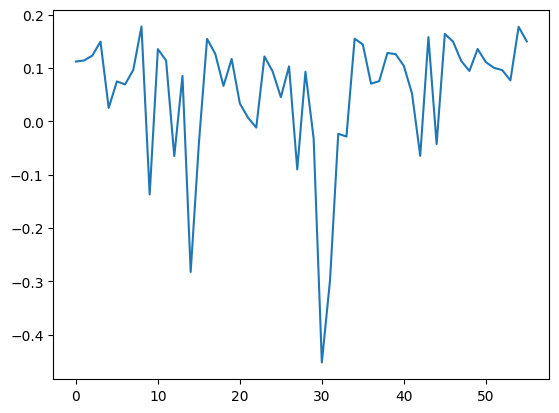

[PPO] Epoch 0: Loss=2.1864, Policy=0.0177, Value=4.3622
[PPO] Epoch 10: Loss=0.5227, Policy=-0.0224, Value=1.1163
[PPO] Epoch 20: Loss=0.1290, Policy=-0.0531, Value=0.3911
[PPO] Epoch 30: Loss=0.0554, Policy=-0.0790, Value=0.2954
[PPO] Epoch 40: Loss=0.0095, Policy=-0.0903, Value=0.2269
[PPO] Epoch 50: Loss=-0.0286, Policy=-0.0943, Value=0.1564
[PPO] Epoch 60: Loss=-0.0607, Policy=-0.1130, Value=0.1298
[PPO] Epoch 70: Loss=-0.0563, Policy=-0.1174, Value=0.1479
[PPO] Epoch 80: Loss=-0.0912, Policy=-0.1258, Value=0.0946
[PPO] Epoch 90: Loss=-0.0886, Policy=-0.1266, Value=0.1014
Approx KL Learned: 0.25121116638183594
Update 8/10 — steps: 1024


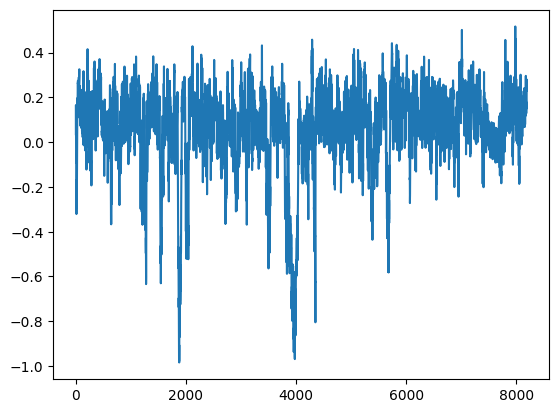

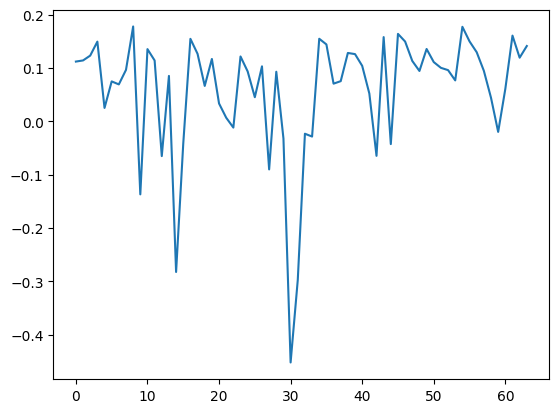

[PPO] Epoch 0: Loss=1.3224, Policy=0.0210, Value=2.6233
[PPO] Epoch 10: Loss=0.2943, Policy=-0.0293, Value=0.6687
[PPO] Epoch 20: Loss=0.0868, Policy=-0.0568, Value=0.3097
[PPO] Epoch 30: Loss=0.0579, Policy=-0.0757, Value=0.2889
[PPO] Epoch 40: Loss=-0.0016, Policy=-0.0848, Value=0.1882
[PPO] Epoch 50: Loss=-0.0366, Policy=-0.0954, Value=0.1392
[PPO] Epoch 60: Loss=-0.0533, Policy=-0.0981, Value=0.1115
[PPO] Epoch 70: Loss=-0.0436, Policy=-0.0998, Value=0.1344
[PPO] Epoch 80: Loss=-0.0571, Policy=-0.1030, Value=0.1148
[PPO] Epoch 90: Loss=-0.0778, Policy=-0.1047, Value=0.0765
Approx KL Learned: 0.2626286447048187
Update 9/10 — steps: 1024


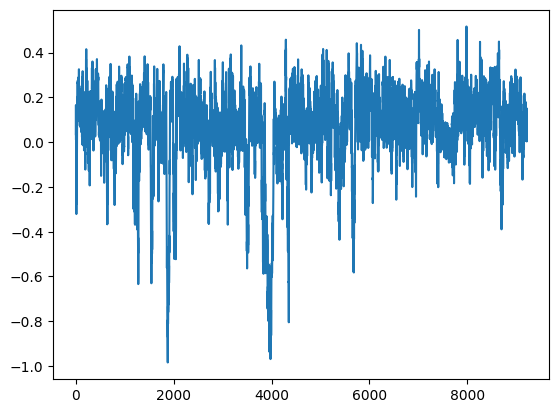

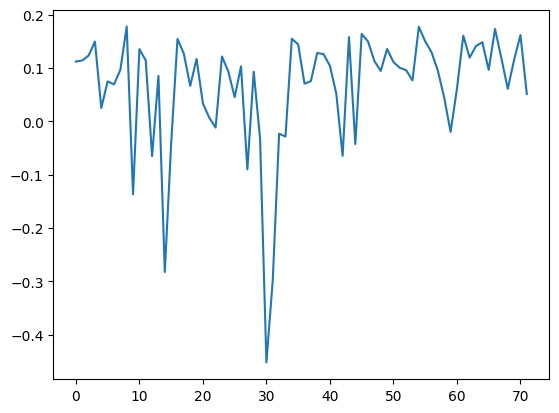

[PPO] Epoch 0: Loss=2.0918, Policy=0.0099, Value=4.1858
[PPO] Epoch 10: Loss=0.5512, Policy=-0.0152, Value=1.1578
[PPO] Epoch 20: Loss=0.1760, Policy=-0.0410, Value=0.4567
[PPO] Epoch 30: Loss=0.0943, Policy=-0.0554, Value=0.3225
[PPO] Epoch 40: Loss=0.0341, Policy=-0.0676, Value=0.2258
[PPO] Epoch 50: Loss=-0.0061, Policy=-0.0757, Value=0.1619
[PPO] Epoch 60: Loss=-0.0218, Policy=-0.0811, Value=0.1410
[PPO] Epoch 70: Loss=-0.0311, Policy=-0.0860, Value=0.1317
[PPO] Epoch 80: Loss=-0.0407, Policy=-0.0894, Value=0.1191
[PPO] Epoch 90: Loss=-0.0437, Policy=-0.0900, Value=0.1146
Approx KL Learned: 0.10229700803756714
Update 10/10 — steps: 1024


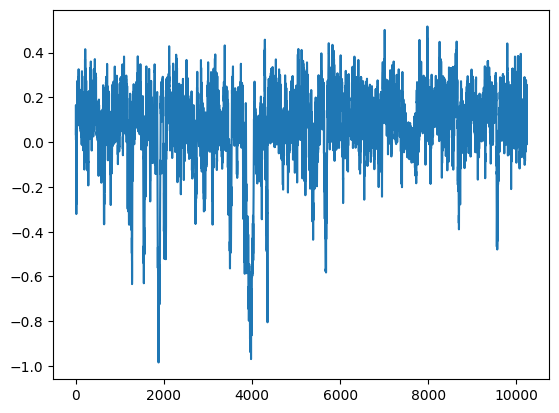

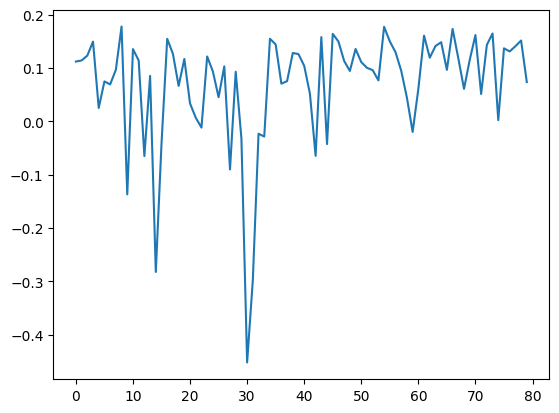

In [19]:
ENTROPY_COEF = 0.02
buf, rewards = train(controller, clip_env, clip_actor_critic, 10)

In [162]:
save_actor_critic(clip_actor_critic, "clip_actor_critic_checkpoint_clip_embed.pt")

[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_clip_embed.pt


In [ ]:
house = dataset["train"][3]
controller = Controller(scene=house, snapToGrid=False, rotateStepDegrees=30)
event = controller.step("Pass")
spawn = event.metadata["agent"]["position"]

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


In [187]:
load_actor_critic(clip_actor_critic, "clip_actor_critic_checkpoint_high_entropy.pt", device=DEVICE)

[🔁] Actor-Critic checkpoint loaded from clip_actor_critic_checkpoint_high_entropy.pt


Init position {'x': 14.083189010620117, 'y': 0.9009993672370911, 'z': 2.8104000091552734}


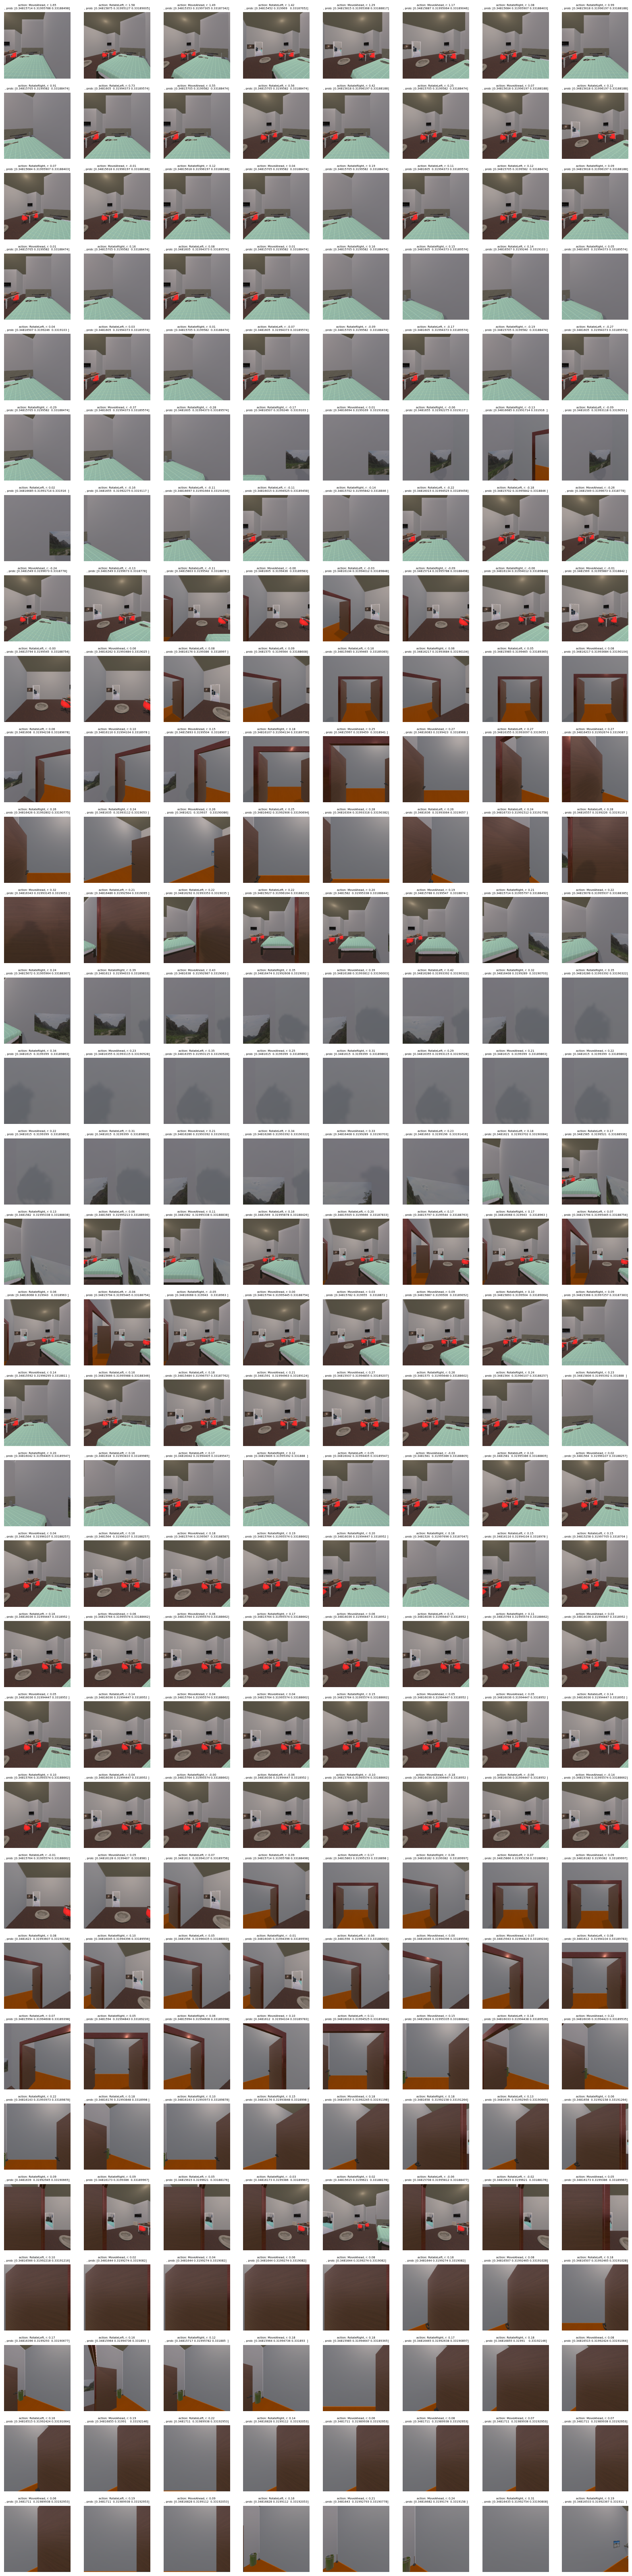

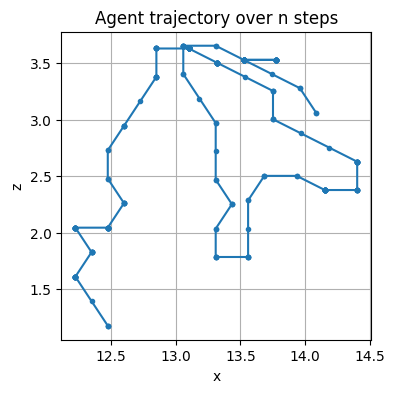

In [18]:
from cons import ACTIONS
from collections import deque
import matplotlib.pyplot as plt
import numpy as np

n = 256
n_row = 32
positions = []

plt.figure(figsize=(n // n_row * 2, n_row * 2))
# event = teleport(controller, {'x': 9.792665481567383, 'y': 0.9009993672370911, 'z': 2.9606857299804688})
event = teleport(controller)
print("Init position", event.metadata["agent"]["position"])
episode_seq = deque(maxlen=EPISODE_STEPS)
for t in range(1, n + 1):
    obs_t = ppo.obs_from_event(event)  # (C,H,W)
    obs_seq = torch.stack(list(episode_seq) + [obs_t], dim=0).unsqueeze(0)
    logits, value = ppo.act_and_value(obs_seq, clip_actor_critic)
    dist = torch.distributions.Categorical(logits=logits)
    # dist = torch.distributions.Categorical(probs=torch.tensor([0.5,0.25,0.25]))
    action_idx = dist.sample()
    # action_idx = np.random.randint(0,4)

    event, reward = clip_env.step_env(controller, action_idx)
    done = t == EPISODE_STEPS

    # Extract agent position from metada
    # ta
    pos = event.metadata["agent"]["position"]
    positions.append((pos["x"], pos["z"]))  # store x,z

    # Plot frame and action
    plt.subplot(n_row, n // n_row, t)
    plt.title("action: " + ACTIONS[action_idx] + ", r: " + f"{reward:.2f}" + "\n, prob: " + str(torch.softmax(logits, dim=0).cpu().numpy()), fontsize=5)
    plt.axis(False)
    plt.imshow(event.frame)

plt.tight_layout()
plt.show()

# ---- Plot 2D trajectory of the agent ----
positions = np.array(positions)
plt.figure(figsize=(4, 4))
plt.plot(positions[:, 0], positions[:, 1], "-o", markersize=3)
plt.xlabel("x")
plt.ylabel("z")
plt.title("Agent trajectory over n steps")
plt.grid(True)
plt.show()


In [948]:
novelty.reset()

img_buffer = []

tensor([0.3384, 0.3403, 0.3716, 0.3354, 0.3110, 0.3008, 0.2163, 0.1621, 0.1206,
        0.0386, 0.0000, 0.2642, 0.3384, 0.3403, 0.3716, 0.3354, 0.3110, 0.3008,
        0.2163, 0.1621, 0.1206, 0.0386, 0.0000, 0.2642, 0.3384, 0.3403, 0.3716,
        0.3354, 0.3110, 0.3008, 0.2163, 0.1621, 0.1206, 0.0386, 0.0000, 0.2642,
        0.3384, 0.3403, 0.3716, 0.3354, 0.3110, 0.3008, 0.2163, 0.1621, 0.1206,
        0.0386, 0.0000, 0.2642, 0.3384, 0.3403, 0.3716, 0.3354, 0.3110, 0.3008,
        0.2163, 0.1621, 0.1206, 0.0386, 0.0000, 0.2642, 0.3384, 0.3403, 0.3716,
        0.3354, 0.3110, 0.3008, 0.2163, 0.1621, 0.1206, 0.0386, 0.0000, 0.2642,
        0.3384, 0.3403, 0.3716, 0.3354, 0.3110, 0.3008, 0.2163, 0.1621, 0.1206,
        0.0386, 0.0000, 0.2642, 0.3384, 0.3403, 0.3716, 0.3354, 0.3110, 0.3008,
        0.2163, 0.1621, 0.2163, 0.3008, 0.2163, 0.1621, 0.1206, 0.0386, 0.1206,
        0.1621, 0.2163, 0.3008, 0.2163, 0.1621, 0.1206, 0.0386, 0.0000, 0.2642,
        0.3384, 0.2642], device='cuda:0'

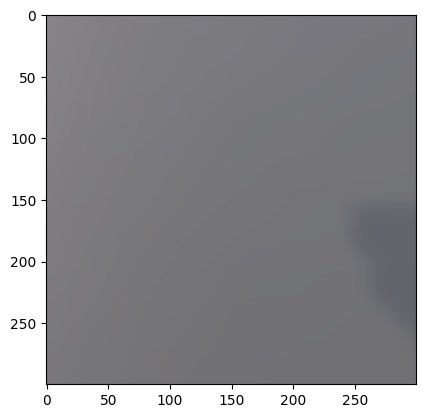

In [1075]:
# teleport(controller, {'x': 8.790684700012207, 'y': 0.9009993672370911, 'z': 2.460493564605713})

action_idx = 2
event = controller.step("RotateRight")

plt.imshow(event.frame)

novelty = clip_env.clip_novelty


frame_np = event.frame
# action_idx = np.random.randint(0,4)
img = Image.fromarray(frame_np)
img_t = novelty.preprocess(img).unsqueeze(0).to(novelty.device)
emb = novelty.model.encode_image(img_t)
emb = emb / emb.norm(dim=-1, keepdim=True)  # normalize to unit sphere
if len(novelty.buffer) == 0:
    novelty.buffer.append(emb)
    img_buffer.append(event.frame)
else:
#     return 0.0  # no past frames to compare yet
    past = torch.cat(list(novelty.buffer), dim=0)  # (N, D)
    sim = F.cosine_similarity(emb, past)        # (N,)
    print((1 - sim), 10 * torch.clamp(sim - 0.98, min=0.0)**2)
    reward = torch.mean((1 - sim) - 10 * torch.clamp(sim - 0.98, min=0.0)**2)
    novelty.buffer.append(emb)
    img_buffer.append(event.frame)
    print(sim)
    print(reward)

In [ ]:
Wall vs wall 0.9614


(<matplotlib.collections.PathCollection at 0x7fe3d001b550>,
 tensor(0.0137, device='cuda:0', dtype=torch.float16, grad_fn=<VarBackward0>),
 tensor(0.7705, device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>))

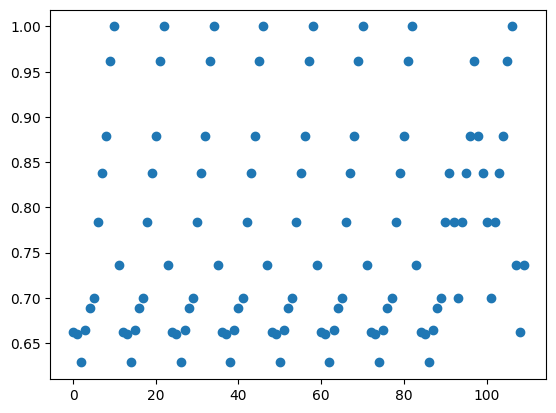

In [1076]:
plt.scatter(np.arange(len(sim)), sim.detach().cpu()), sim.var(), sim.mean()

(<matplotlib.collections.PathCollection at 0x7fe5487c1490>,
 tensor(0.0191, device='cuda:0', dtype=torch.float16, grad_fn=<VarBackward0>),
 tensor(0.7900, device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>))

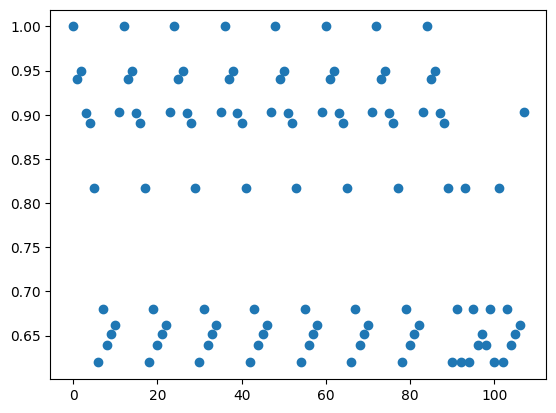

In [1073]:
plt.scatter(np.arange(len(sim)), sim.detach().cpu()), sim.var(), sim.mean()

In [17]:
controller.stop()